# 리튬 위험 지수 예측 모델

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# GPU 사용 확인

import torch
torch.cuda.is_available()

True

In [ ]:
# matplotlib 한국말 출력
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,524 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and dire

In [ ]:
# 모듈 실행
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고창 무시, 한국말 폰트 설정
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False


## 리튬 데이터 통합

In [ ]:
# 데이터 불러오기

# 파일 경로
file_paths = {
    '달러 환율' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/달러환율.csv',
    '위안 환율' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/위안환율.csv',
    '리튬 검색 수' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/구글트렌드_리튬.csv',
    '가격변동지수' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/가격변동지수_리튬.csv',
    '광물종합지수' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/광물종합지수_리튬.csv',
    '시장전망지표' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/시장전망지표_리튬.csv',
    '리튬 가격 예측' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/가격예측데이터_리튬.csv',
    '수급안정화지수' : '/content/drive/MyDrive/산업통상자원부/리튬_데이터/수급안정화지수_리튬.csv'

}

# 데이터 로드
dollar_exchange = pd.read_csv(file_paths['달러 환율'], parse_dates=['date'], index_col='date', encoding='cp949')
yuan_exchange = pd.read_csv(file_paths['위안 환율'], parse_dates=['date'], index_col='date', encoding='cp949')
lithium_search = pd.read_csv(file_paths['리튬 검색 수'], parse_dates=['date'], index_col='date', dayfirst=True, encoding='cp949')
price_index = pd.read_csv(file_paths['가격변동지수'], parse_dates=['date'], index_col='date', encoding='cp949')
mineral_composite_index = pd.read_csv(file_paths['광물종합지수'], parse_dates=['date'], index_col='date', encoding='cp949')
market_outlook = pd.read_csv(file_paths['시장전망지표'], parse_dates=['date'], index_col='date', encoding='cp949')
lithium_price_forecast = pd.read_csv(file_paths['리튬 가격 예측'], parse_dates=['date'], index_col='date', encoding='cp949')
supply_stability_index = pd.read_csv(file_paths['수급안정화지수'], parse_dates=['date'], index_col='date', encoding='cp949')


In [ ]:
# 구글 트렌드 리튬 데이터 로드 및 인덱스 변환
lithium_search.index = pd.to_datetime(lithium_search.index, format='%y-%b')
lithium_search.index = lithium_search.index.strftime('%Y.%m.%d')
lithium_search.index = pd.to_datetime(lithium_search.index, format='%Y.%m.%d')
lithium_search.head()

,검색수
date,
2004-01-01,59
2004-02-01,58
2004-03-01,59
2004-04-01,58
2004-05-01,55


In [ ]:
# 데이터 병합을 위한 기준 날짜 생성
date_range = pd.date_range(start='2018-01-01', end='2024-05-31', freq='D')
combined_data = pd.DataFrame(index=date_range)

# 데이터 병합
combined_data = combined_data.join(dollar_exchange, how='left', lsuffix='_dollar', rsuffix='_yuan')
combined_data = combined_data.join(yuan_exchange, how='left', lsuffix='_yuan')
combined_data = combined_data.join(lithium_search, how='left', lsuffix='_search')
combined_data = combined_data.join(price_index, how='left', lsuffix='_price_index')
combined_data = combined_data.join(mineral_composite_index, how='left', lsuffix='_mineral')
combined_data = combined_data.join(market_outlook, how='left', lsuffix='_market_outlook')
combined_data = combined_data.join(lithium_price_forecast, how='left', lsuffix='_price_forecast')
combined_data = combined_data.join(supply_stability_index, how='left', lsuffix='_supply_stability')
combined_data.head()

,매매기준율(전일대비)_yuan,기준환율_yuan,매매기준율(전일대비),기준환율,검색수,기준가격,등락가,등락비율,광물종합지수,주등락가,...,전월대비 등락가,전월대비 등락율,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,예측가격,수급안정화지수,실질가격(탄산리튬 중국 내수가격),가격단위
2018-01-01,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,...,-0.09,-1.96,NaN,NaN,NaN,NaN,145.54,4.480432,152.422786,RMB/kg
2018-01-02,"1,062.00하락-5.50","1,071.40",163.61하락-0.18,163.65,NaN,150.0,0.0,0.00,"1,844.20",15.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,"1,065.50상승3.50","1,064.30",163.84상승0.23,163.82,NaN,151.0,1.0,0.67,"1,859.25",15.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,"1,064.50하락-1.00","1,065.40",163.88상승0.04,163.90,NaN,150.0,-1.0,-0.66,"1,858.27",-0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,"1,063.50하락-1.00","1,065.50",164.20상승0.32,163.92,NaN,150.0,0.0,0.00,"1,869.72",11.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
combined_data.columns

Index(['매매기준율(전일대비)_yuan', '기준환율_yuan', '매매기준율(전일대비)', '기준환율', '검색수', '기준가격',
       '등락가', '등락비율', '광물종합지수', '주등락가', '주등락율', 'Unnamed: 4_market_outlook',
       'Unnamed: 5_market_outlook', 'Unnamed: 6_market_outlook',
       'Unnamed: 7_market_outlook', '시장전망지표', '전월대비  등락가', '전월대비 등락율',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', '예측가격',
       '수급안정화지수', '실질가격(탄산리튬 중국 내수가격)', '가격단위'],
      dtype='object')

In [ ]:
# 파일 추출
combined_data.to_csv('combined_data.csv', encoding='EUC-KR')

In [ ]:
combined_data.tail()

,매매기준율(전일대비)_yuan,기준환율_yuan,매매기준율(전일대비),기준환율,검색수,기준가격,등락가,등락비율,광물종합지수,주등락가,...,전월대비 등락가,전월대비 등락율,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,예측가격,수급안정화지수,실질가격(탄산리튬 중국 내수가격),가격단위
2024-05-27,"1,364.00하락-4.00","1,370.00",187.93하락-0.56,188.82,NaN,NaN,NaN,NaN,"2,966.33",-0.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-28,"1,360.00하락-4.00","1,365.40",187.32하락-0.61,188.15,NaN,NaN,NaN,NaN,"2,959.51",-6.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

### 데이터 전처리

In [ ]:
filepath = '/content/drive/MyDrive/산업통상자원부/데이터/combined_data (1).csv'

df = pd.read_csv(filepath, encoding='cp949')
df.head()

,date,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices
0,2018-01-01,"1,062.00하락-5.50",1071.4,163.61하락-0.18,163.65,48.0,150.0,0.0,0.00,1844.2,15.06,0.82,4.55,-0.09,-1.96,145.54,4.480432,152.422786
1,2018-01-02,"1,062.00하락-5.50","1,071.40",163.61하락-0.18,163.65,NaN,150.0,0.0,0.00,"1,844.20",15.06,0.82,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,"1,065.50상승3.50","1,064.30",163.84상승0.23,163.82,NaN,151.0,1.0,0.67,"1,859.25",15.06,0.82,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,"1,064.50하락-1.00","1,065.40",163.88상승0.04,163.90,NaN,150.0,-1.0,-0.66,"1,858.27",-0.98,-0.05,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,"1,063.50하락-1.00","1,065.50",164.20상승0.32,163.92,NaN,150.0,0.0,0.00,"1,869.72",11.44,0.62,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 결측값 확인
df.isnull().sum()

date                                             0
increase_yuan                                  760
yuan                                           760
increase_dollar                                760
dollar                                         760
search                                        2266
price                                          790
fluctuating_price                              790
fluctuation_rate                               790
mineral_index                                  673
mineral_index_fluctuating                      673
mineral_index_rate                             673
market_forcast_indicators                     2267
market_forcast_indicators_fluctuating         2267
market_forcast_indicators_fluctuating_rate    2267
estimated_price                               2317
stabilization_index                           2280
chindese_domestic_prices                      2280
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        2343 non-null   object 
 1   increase_yuan                               1583 non-null   object 
 2   yuan                                        1583 non-null   object 
 3   increase_dollar                             1583 non-null   object 
 4   dollar                                      1583 non-null   float64
 5   search                                      77 non-null     float64
 6   price                                       1553 non-null   float64
 7   fluctuating_price                           1553 non-null   float64
 8   fluctuation_rate                            1553 non-null   float64
 9   mineral_index                               1670 non-null   object 
 10  mineral_inde

In [ ]:
df.describe(include='all')

,date,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices
count,2343,1583,1583,1583,1583.000000,77.000000,1553.000000,1553.000000,1553.000000,1670,1670.000000,1670.000000,76.000000,76.000000,76.000000,26.000000,63.000000,63.000000
unique,2343,1501,1137,1575,NaN,NaN,NaN,NaN,NaN,1652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2018-01-01,"1,128.00하락-4.00","1,303.80",163.61하락-0.18,NaN,NaN,NaN,NaN,NaN,"1,652.94",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3,6,2,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,177.105016,66.194805,165.163297,-0.029942,-0.015164,NaN,0.685952,0.034240,41.624342,0.951447,9.541184,163.280385,35.525447,165.365449
std,NaN,NaN,NaN,NaN,9.730706,14.440476,152.656965,2.612702,1.319160,NaN,28.154151,0.998867,26.698950,7.135900,37.647981,152.146707,24.385607,165.004595
min,NaN,NaN,NaN,NaN,161.020000,47.000000,33.500000,-16.000000,-10.420000,NaN,-167.130000,-4.830000,1.620000,-21.790000,-67.760000,34.240000,1.494917,32.845897
25%,NaN,NaN,NaN,NaN,169.225000,53.000000,64.500000,0.000000,0.000000,NaN,-9.915000,-0.480000,13.017500,-0.605000,-1.622500,66.222500,9.768415,51.328933
50%,NaN,NaN,NaN,NaN,173.640000,61.000000,88.500000,0.000000,0.000000,NaN,0.000000,0.000000,44.350000,0.650000,1.915000,86.520000,40.144639,81.554083
75%,NaN,NaN,NaN,NaN,185.200000,78.000000,202.500000,0.000000,0.000000,NaN,11.460000,0.550000,67.475000,4.535000,15.490000,222.462500,58.835874,200.662645


In [ ]:
# increase_yuan과 increase_dollar를 상승, 하락 수치만 남기도록하는 함수

def extract_numeric_part(value):
    if pd.isna(value):
        return value
    # 쉼표 제거
    value = value.replace(',', '')
    # '상승' 또는 '하락' 이후의 숫자 부분을 추출
    if '상승' in value:
        numeric_part = value.split('상승')[-1]
    elif '하락' in value:
        numeric_part = value.split('하락')[-1]
    else:
        numeric_part = value
    # 숫자와 소수점만 남김
    return float(numeric_part)

In [ ]:
# 해당 열들에 적용 후 결과 확인

for col in ['increase_yuan', 'increase_dollar']:
    df[col] = df[col].apply(lambda x: extract_numeric_part(x) if isinstance(x, str) else x)

print(df[['increase_yuan','increase_dollar']])

      increase_yuan  increase_dollar
0              -5.5            -0.18
1              -5.5            -0.18
2               3.5             0.23
3              -1.0             0.04
4              -1.0             0.32
...             ...              ...
2338           -4.0            -0.56
2339           -4.0            -0.61
2340            NaN              NaN
2341            NaN              NaN
2342            NaN              NaN

[2343 rows x 2 columns]


In [ ]:
# 'yuan', 'mineral_index' columns 쉼표 제거하고 float로 type 변경

def clean_and_convert(value):
    if isinstance(value, str):
        return float(value.replace(',',''))
    return value

df['yuan'] = df['yuan'].apply(clean_and_convert)
df['mineral_index'] = df['mineral_index'].apply(clean_and_convert)
df['yuan'].dtypes, df['mineral_index'].dtypes

(dtype('float64'), dtype('float64'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        2343 non-null   object 
 1   increase_yuan                               1583 non-null   float64
 2   yuan                                        1583 non-null   float64
 3   increase_dollar                             1583 non-null   float64
 4   dollar                                      1583 non-null   float64
 5   search                                      77 non-null     float64
 6   price                                       1553 non-null   float64
 7   fluctuating_price                           1553 non-null   float64
 8   fluctuation_rate                            1553 non-null   float64
 9   mineral_index                               1670 non-null   float64
 10  mineral_inde

In [ ]:
# 파일 추출
df.to_csv('lithium_data.csv')

### 결측값 처리

In [ ]:
filepath = '/content/drive/MyDrive/산업통상자원부/데이터/lithium_data (1).csv'

df = pd.read_csv(filepath, encoding='cp949', parse_dates=['date'], index_col='date')
df.head()

,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices
date,,,,,,,,,,,,,,,,,
2018-01-01,-5.5,1071.4,-0.18,163.65,48.0,150.0,0.0,0.00,1844.20,15.06,0.82,4.55,-0.09,-1.96,145.54,4.480432,152.422786
2018-01-02,-5.5,1071.4,-0.18,163.65,NaN,150.0,0.0,0.00,1844.20,15.06,0.82,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,3.5,1064.3,0.23,163.82,NaN,151.0,1.0,0.67,1859.25,15.06,0.82,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,-1.0,1065.4,0.04,163.90,NaN,150.0,-1.0,-0.66,1858.27,-0.98,-0.05,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,-1.0,1065.5,0.32,163.92,NaN,150.0,0.0,0.00,1869.72,11.44,0.62,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.head()

,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices
date,,,,,,,,,,,,,,,,,
2018-01-01,-5.5,1071.4,-0.18,163.65,48.0,150.0,0.0,0.00,1844.20,15.06,0.82,4.55,-0.09,-1.96,145.54,4.480432,152.422786
2018-01-02,-5.5,1071.4,-0.18,163.65,NaN,150.0,0.0,0.00,1844.20,15.06,0.82,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,3.5,1064.3,0.23,163.82,NaN,151.0,1.0,0.67,1859.25,15.06,0.82,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,-1.0,1065.4,0.04,163.90,NaN,150.0,-1.0,-0.66,1858.27,-0.98,-0.05,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,-1.0,1065.5,0.32,163.92,NaN,150.0,0.0,0.00,1869.72,11.44,0.62,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 선형 보간법 적용
df_interpolated = df.interpolate(method='linear')

# 결과 확인
df_interpolated.head()

,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices
date,,,,,,,,,,,,,,,,,
2018-01-01,-5.5,1071.4,-0.18,163.65,48.000000,150.0,0.0,0.00,1844.20,15.06,0.82,4.550000,-0.090000,-1.960000,145.540000,4.480432,152.422786
2018-01-02,-5.5,1071.4,-0.18,163.65,48.032258,150.0,0.0,0.00,1844.20,15.06,0.82,4.559355,-0.077742,-1.688065,145.325778,4.499538,152.333911
2018-01-03,3.5,1064.3,0.23,163.82,48.064516,151.0,1.0,0.67,1859.25,15.06,0.82,4.568710,-0.065484,-1.416129,145.111556,4.518644,152.245035
2018-01-04,-1.0,1065.4,0.04,163.90,48.096774,150.0,-1.0,-0.66,1858.27,-0.98,-0.05,4.578065,-0.053226,-1.144194,144.897333,4.537750,152.156160
2018-01-05,-1.0,1065.5,0.32,163.92,48.129032,150.0,0.0,0.00,1869.72,11.44,0.62,4.587419,-0.040968,-0.872258,144.683111,4.556856,152.067285


In [ ]:
# 날짜 형식 변경
df_interpolated.index = pd.to_datetime(df_interpolated.index, format='%Y-%m-%d')

In [ ]:
# 결측치 사라짐
df_interpolated.isnull().sum()

increase_yuan                                 0
yuan                                          0
increase_dollar                               0
dollar                                        0
search                                        0
price                                         0
fluctuating_price                             0
fluctuation_rate                              0
mineral_index                                 0
mineral_index_fluctuating                     0
mineral_index_rate                            0
market_forcast_indicators                     0
market_forcast_indicators_fluctuating         0
market_forcast_indicators_fluctuating_rate    0
estimated_price                               0
stabilization_index                           0
chindese_domestic_prices                      0
dtype: int64

In [ ]:
# 데이터 확인

df_interpolated.describe(include='all')

,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices
count,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000
mean,50.395433,1207.371596,1.448440,177.141927,66.365984,164.840205,0.039031,0.002956,2286.792038,0.611793,0.031748,42.580856,0.894661,9.406773,163.074782,37.763101,183.567428
std,222.775229,91.086569,14.634234,9.749037,14.155832,152.294660,2.547952,1.256030,720.953690,25.982245,0.931066,26.464768,6.410003,31.077782,147.605026,22.021701,152.430487
min,-57.000000,1057.600000,-4.690000,161.020000,47.000000,33.500000,-16.000000,-10.420000,1280.730000,-167.130000,-4.830000,1.620000,-21.790000,-67.760000,34.240000,1.494917,32.845897
25%,-3.000000,1129.500000,-0.350000,169.235000,53.065591,64.500000,0.000000,0.000000,1643.695000,-9.261667,-0.450000,13.526613,-0.599032,-1.107043,62.777692,13.555979,62.797453
50%,0.500000,1188.000000,0.046667,173.610000,61.000000,88.500000,0.000000,0.000000,2069.660000,0.210000,0.010000,44.478387,0.752000,2.475161,86.770330,46.180899,116.087551
75%,4.500000,1295.650000,0.420000,185.158333,79.850389,197.166667,0.000000,0.000000,2824.063333,11.075000,0.515000,68.825968,4.230000,18.222968,232.811154,48.939557,262.175101
max,1425.500000,1436.600000,199.360000,201.790000,100.000000,581.500000,20.000000,11.630000,4212.580000,360.500000,10.180000,79.880000,21.480000,167.340000,541.700000,70.783676,568.206608


### 파생변수 생성

In [ ]:
# 광물변동지수 생성
# 광물종합지수의 이동 평균과 이동 표준편차를 계산

window_size = 30 # 30일을 기준으로 사용

df_interpolated['mineral_index_ma'] = df_interpolated['mineral_index'].rolling(window=window_size, min_periods=1).mean()
df_interpolated['mineral_index_msd'] = df_interpolated['mineral_index'].rolling(window=window_size, min_periods=1).std()

df_interpolated['mineral_variation_index'] = df_interpolated['mineral_index_ma'] / df_interpolated['mineral_index_msd']


# 결과확인

df_interpolated[['mineral_index', 'mineral_index_ma', 'mineral_index_msd', 'mineral_variation_index']].head()



,mineral_index,mineral_index_ma,mineral_index_msd,mineral_variation_index
date,,,,
2018-01-01,1844.20,1844.200000,NaN,NaN
2018-01-02,1844.20,1844.200000,0.000000,inf
2018-01-03,1859.25,1849.216667,8.689122,212.819749
2018-01-04,1858.27,1851.480000,8.415735,220.002168
2018-01-05,1869.72,1855.128000,10.938829,169.591103


In [ ]:
# 결측치 처리
print(df_interpolated['mineral_variation_index'].isnull().sum())
df_interpolated = df_interpolated.fillna(method='bfill')
print(df_interpolated['mineral_variation_index'].isnull().sum())

1
0


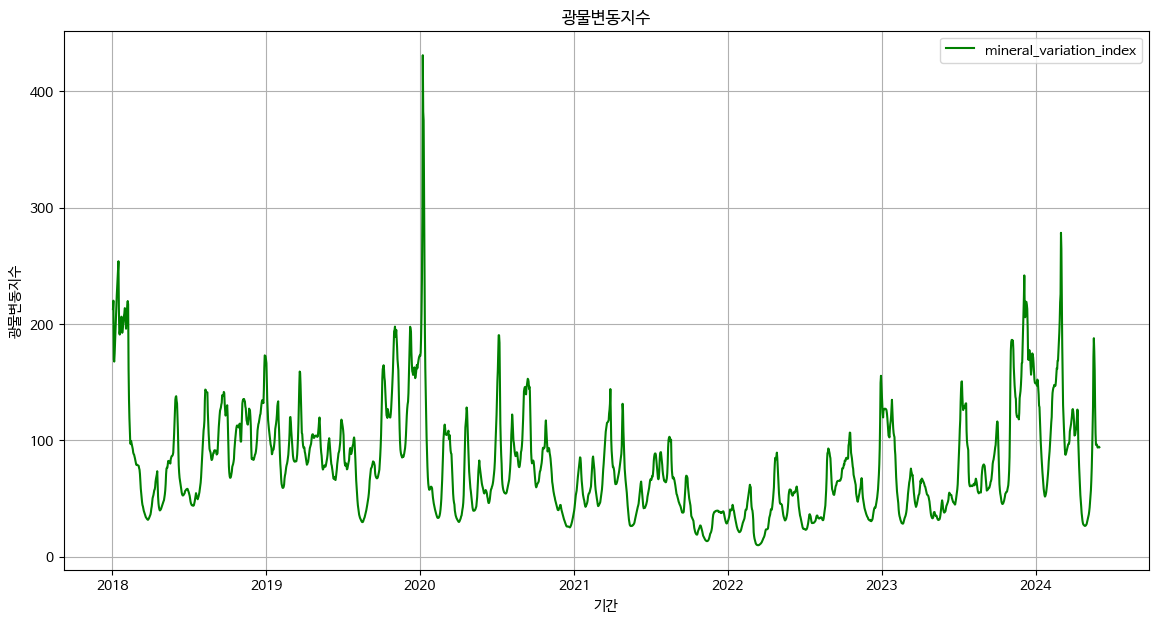

In [ ]:
# mineral_variation_index 시각화
plt.figure(figsize=(14, 7))
plt.plot(df_interpolated.index, df_interpolated['mineral_variation_index'], label='mineral_variation_index', color='green')
plt.title('광물변동지수')
plt.xlabel('기간')
plt.ylabel('광물변동지수')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 필요없는 columns 삭제 'mineral_index_ma', 'mineral_index_msd'
df_interpolated.drop(['mineral_index_ma', 'mineral_index_msd'], axis=1, inplace=True)

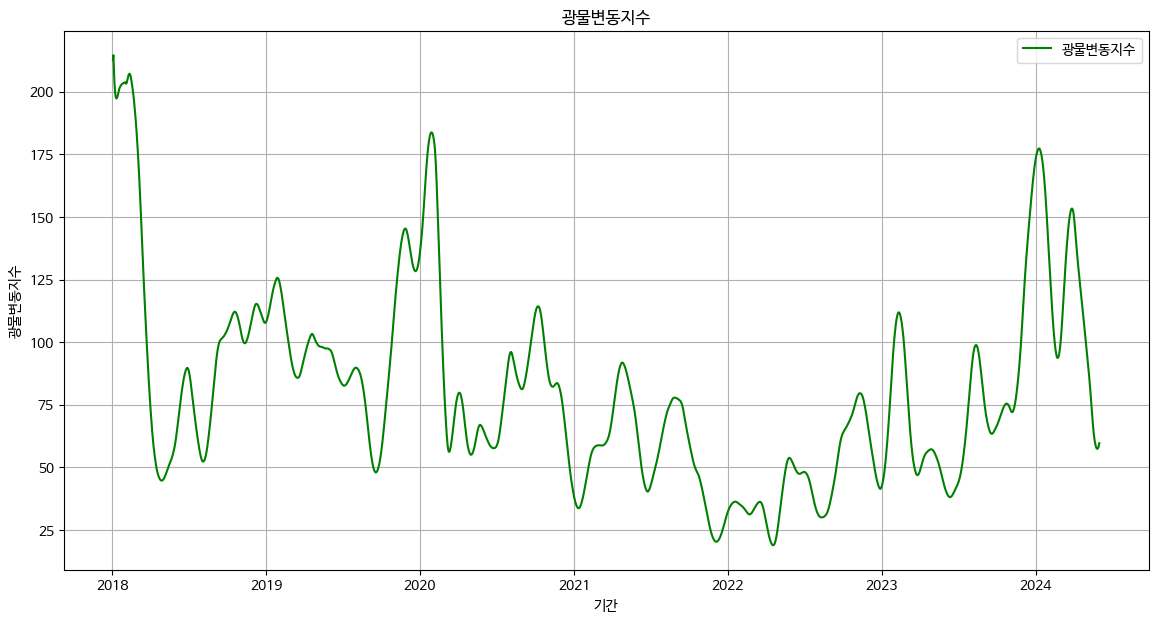

In [ ]:
# 광물변동지수 노이즈 제거

# 이동 평균 적용 (노이즈 감소)
window_size = 30  # 30일 이동 평균 사용
df_interpolated['mineral_variation_index'] = df_interpolated['mineral_variation_index'].rolling(window=window_size, min_periods=1).mean()

# 광물변동지수 시각화
plt.figure(figsize=(14, 7))
plt.plot(df_interpolated.index, df_interpolated['mineral_variation_index'], label='광물변동지수', color='green')
plt.title('광물변동지수')
plt.xlabel('기간')
plt.ylabel('광물변동지수')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# economic_index 생성
# 환율 변동 * weight_1 + 광물변동지수 * weight_2

weight_1, weight_2 = 0.6, 0.4

df_interpolated['economic_index'] = (df_interpolated['increase_dollar'] * weight_1) + (df_interpolated['mineral_variation_index'] * weight_2)

df_interpolated['economic_index'].head(10)

date
2018-01-01          NaN
2018-01-02          NaN
2018-01-03    85.265900
2018-01-04    85.870141
2018-01-05    84.196673
2018-01-06    82.439725
2018-01-07    81.097888
2018-01-08    80.157736
2018-01-09    79.009193
2018-01-10    79.126307
Name: economic_index, dtype: float64

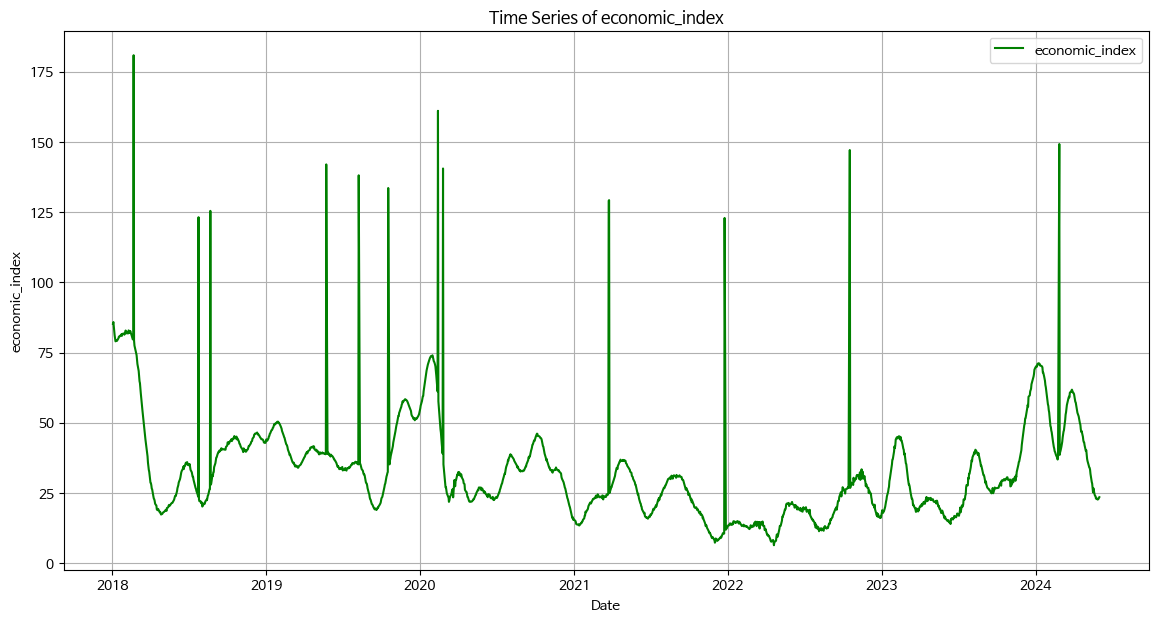

In [ ]:
# 경제 지수 시각화
plt.figure(figsize=(14, 7))
plt.plot(df_interpolated.index, df_interpolated['economic_index'], label='economic_index', color='green')
plt.title('Time Series of economic_index')
plt.xlabel('Date')
plt.ylabel('economic_index')
plt.legend()
plt.grid(True)
plt.show()

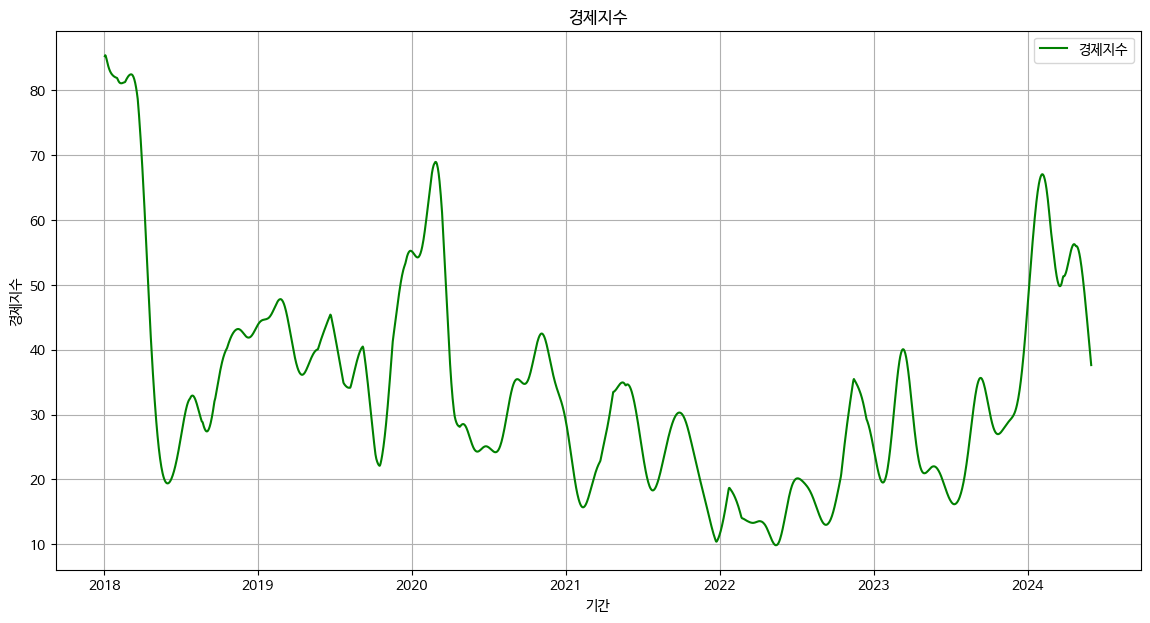

In [ ]:
# 노이즈 제거

# 이동 평균 적용 (노이즈 감소)
window_size = 30  # 30일 이동 평균 사용
df_interpolated['economic_index'] = df_interpolated['economic_index'].rolling(window=window_size, min_periods=1).mean()

# 경제 지수 시각화
plt.figure(figsize=(14, 7))
plt.plot(df_interpolated.index, df_interpolated['economic_index'], label='경제지수', color='green')
plt.title('경제지수')
plt.xlabel('기간')
plt.ylabel('경제지수')
plt.legend()
plt.grid(True)
plt.show()

            estimated_price_index
date                             
2018-01-01             118.680000
2018-01-02             118.574760
2018-01-03             118.769520
2018-01-04             118.364280
2018-01-05             118.259039


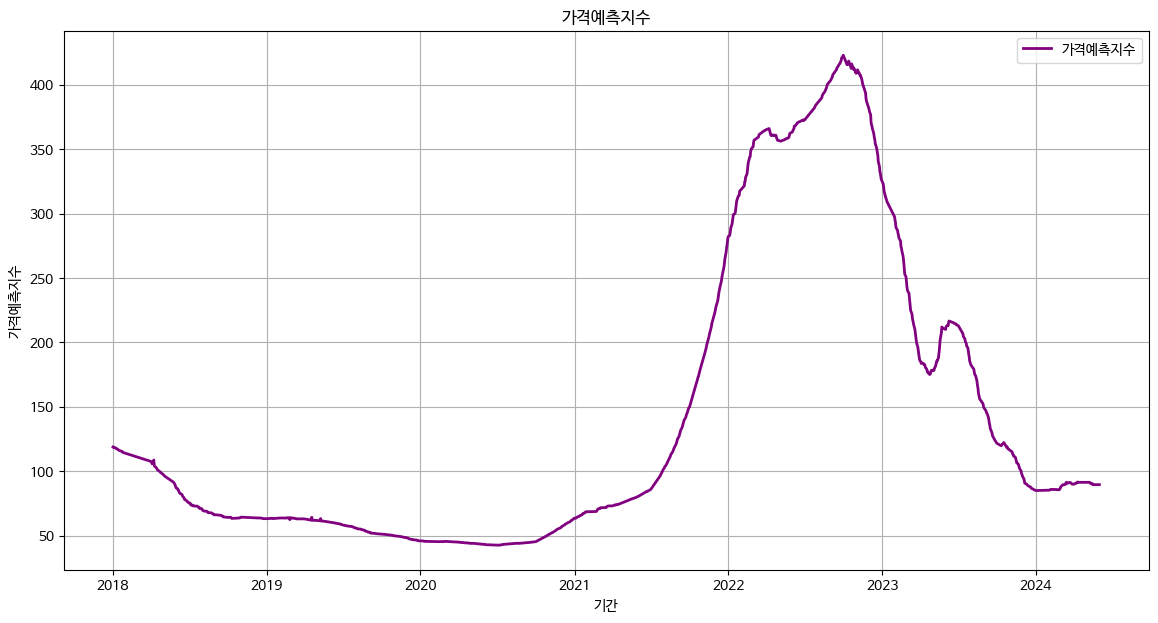

In [ ]:
# 가격예측지수 생성
# 예측가격 * 0.5 + 기준가격 * 0.3 + 시장전망지표 * 0.2

# 가중치 설정
weights = {
    'estimated_price': 0.5,
    'price': 0.3,
    'market_forcast_indicators': 0.2
}

# 가격예측지수 생성
df_interpolated['estimated_price_index'] = sum(df_interpolated[col] * weight for col, weight in weights.items())

# 결과 확인
print(df_interpolated[['estimated_price_index']].head())

# 가격예측지수 시각화
plt.figure(figsize=(14, 7))
plt.plot(df_interpolated.index, df_interpolated['estimated_price_index'], label='가격예측지수', color='purple', linewidth=2)
plt.title('가격예측지수')
plt.xlabel('기간')
plt.ylabel('가격예측지수')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 파일 추출
df_interpolated.to_csv('final_lithium_data.csv')

### 상관계수 확인

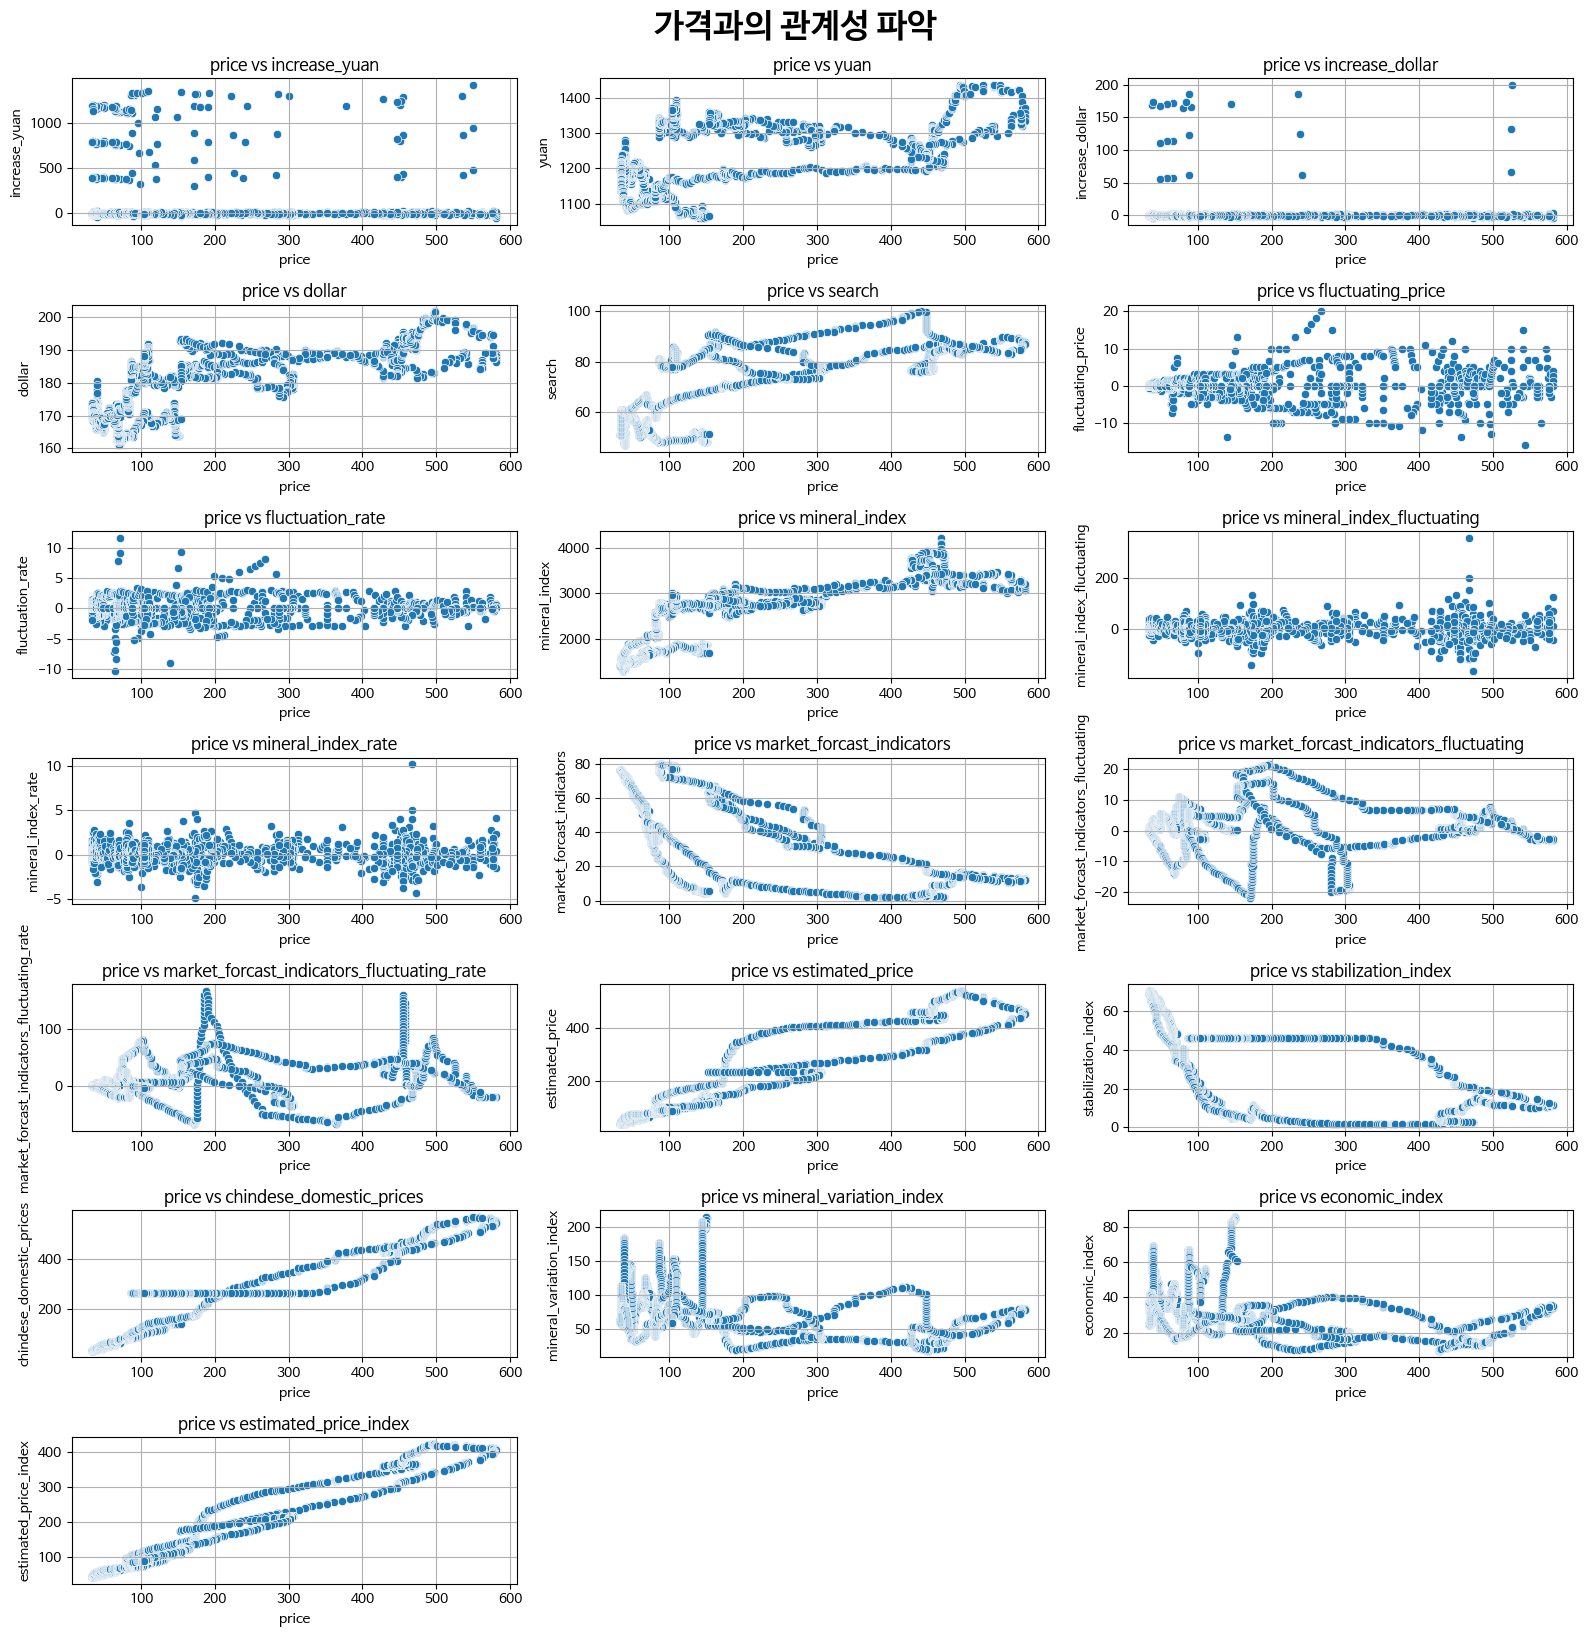

In [ ]:
# 'price'와의 scatter plot
plt.figure(figsize=(16, 16))
price_columns = df_interpolated.columns.drop(['price'])  # price와 date를 제외한 모든 열 선택
for i, column in enumerate(price_columns):
    plt.subplot((len(price_columns) + 2) // 3, 3, i + 1)
    sns.scatterplot(data=df_interpolated, x='price', y=column)
    plt.title(f'price vs {column}')
    plt.xlabel('price')
    plt.ylabel(column)
    plt.grid(True)
plt.tight_layout()
plt.suptitle('가격과의 관계성 파악', fontsize=24, fontweight='bold', y=1.02)
plt.show()

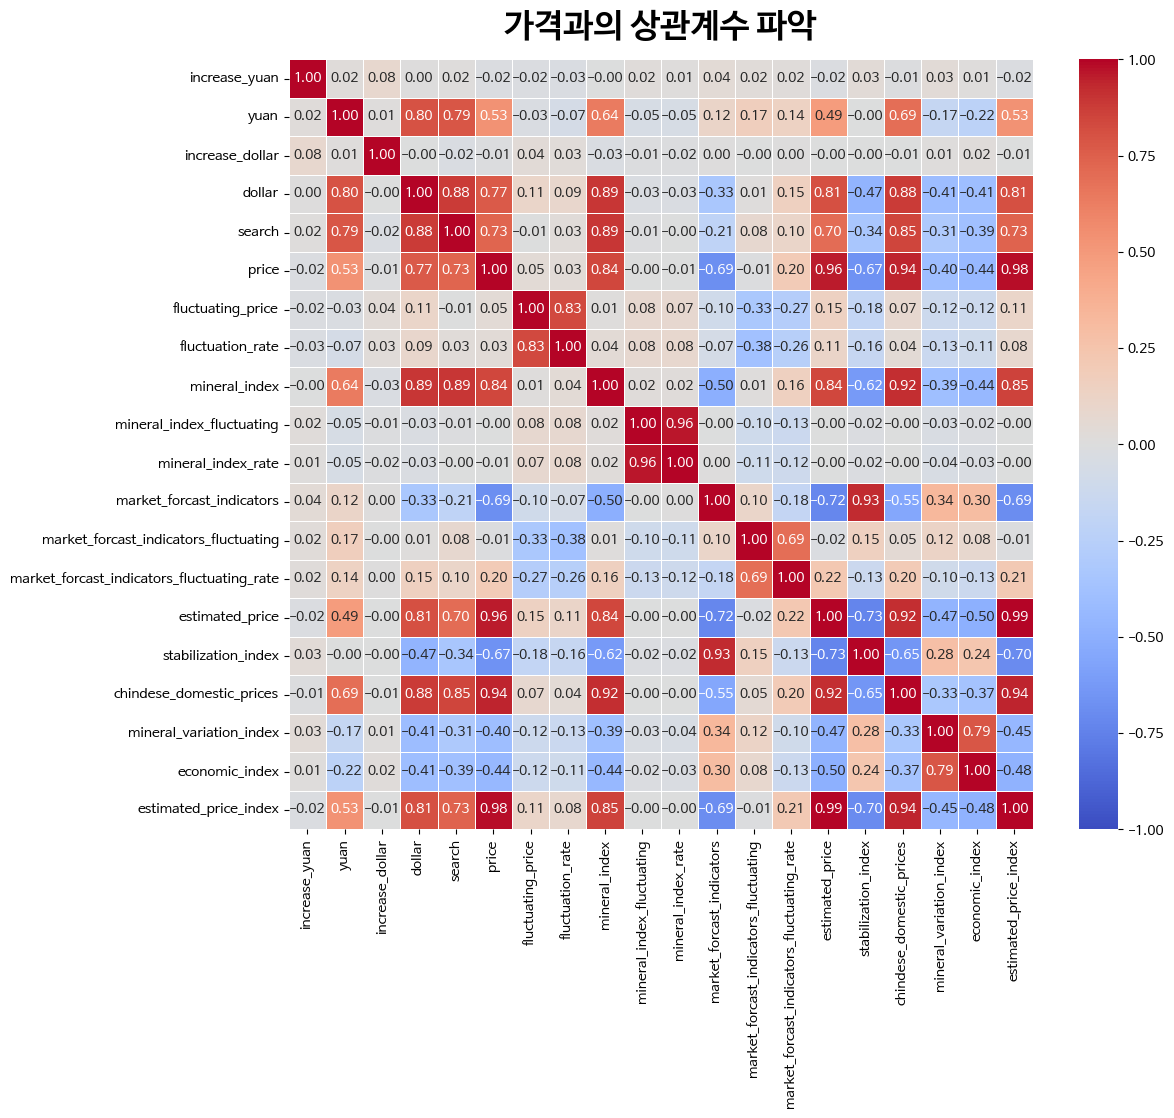

In [ ]:
# 상관관계 확인
# 히트맵
plt.figure(figsize=(12, 10))
correlation_matrix = df_interpolated.corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title('가격과의 상관계수 파악', fontsize=24, fontweight='bold', y=1.02)
plt.show()

In [ ]:

# price와의 상관관계 순위
correlation_with_estimated_price = abs(correlation_matrix['price']).sort_values(ascending=False)

correlation_with_estimated_price

price                                         1.000000
chindese_domestic_prices                      0.994216
estimated_price_index                         0.986193
estimated_price                               0.964455
mineral_index                                 0.912036
search                                        0.872935
dollar                                        0.871639
market_forcast_indicators                     0.725794
yuan                                          0.724156
date                                          0.699528
stabilization_index                           0.693690
economic_index                                0.384780
mineral_variation_index                       0.372313
market_forcast_indicators_fluctuating_rate    0.228713
fluctuating_price                             0.048991
market_forcast_indicators_fluctuating         0.048572
fluctuation_rate                              0.031744
increase_yuan                                 0.012128
increase_d

##  모델링

## 추가적인 인사이트

In [ ]:
# 코드를 실행하기 위한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import seaborn as sns

In [ ]:
file_path = '/content/drive/MyDrive/산업통상자원부/데이터/final_lithium_data.csv'
df_interpolated = pd.read_csv(file_path, parse_dates=['date'], index_col='date')


df_interpolated.head()

,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices,mineral_variation_index,economic_index,estimated_price_index
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,-5.5,1071.4,-0.18,163.65,48.000000,150.0,0.0,0.00,1844.20,15.06,0.82,4.550000,-0.090000,-1.960000,145.540000,4.480432,152.422786,212.819749,85.265900,118.680000
2018-01-02,-5.5,1071.4,-0.18,163.65,48.032258,150.0,0.0,0.00,1844.20,15.06,0.82,4.559355,-0.077742,-1.688065,145.325778,4.499538,152.333911,212.819749,85.265900,118.574760
2018-01-03,3.5,1064.3,0.23,163.82,48.064516,151.0,1.0,0.67,1859.25,15.06,0.82,4.568710,-0.065484,-1.416129,145.111556,4.518644,152.245035,212.819749,85.265900,118.769520
2018-01-04,-1.0,1065.4,0.04,163.90,48.096774,150.0,-1.0,-0.66,1858.27,-0.98,-0.05,4.578065,-0.053226,-1.144194,144.897333,4.537750,152.156160,216.410958,85.927141,118.364280
2018-01-05,-1.0,1065.5,0.32,163.92,48.129032,150.0,0.0,0.00,1869.72,11.44,0.62,4.587419,-0.040968,-0.872258,144.683111,4.556856,152.067285,200.804340,84.122673,118.259039


In [ ]:
df_interpolated.tail(90)

,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices,mineral_variation_index,economic_index,estimated_price_index
date,,,,,,,,,,,,,,,,,,,,
2024-03-03,331.0,1334.075,-0.43,185.055,78.516129,98.5,2.666667,2.78,2695.93,20.816667,0.776667,79.550645,-0.319677,-0.402258,86.396703,46.180899,262.175101,162.028731,49.961909,88.658481
2024-03-04,-4.5,1334.100,-0.64,185.120,78.774194,99.5,3.000000,3.11,2706.03,30.290000,1.130000,79.460968,-0.404516,-0.508387,86.389231,46.180899,262.175101,165.064436,50.999088,88.936809
2024-03-05,1.0,1330.100,0.06,184.550,79.032258,101.5,2.000000,2.01,2713.45,7.420000,0.270000,79.371290,-0.489355,-0.614516,86.381758,46.180899,262.175101,166.965809,52.114809,89.515137
2024-03-06,1334.0,1333.200,-0.05,185.080,79.290323,101.5,0.000000,0.00,2723.66,10.210000,0.380000,79.281613,-0.574194,-0.720645,86.374286,46.180899,262.175101,167.878388,53.276104,89.493465
2024-03-07,-3.0,1335.700,-0.30,185.320,79.548387,101.5,0.000000,0.00,2710.67,-12.990000,-0.480000,79.191935,-0.659032,-0.826774,86.366813,46.180899,262.175101,168.256177,54.426159,89.471794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,-4.0,1370.000,-0.56,188.820,78.000000,103.5,0.000000,0.00,2966.33,-0.720000,-0.020000,76.950000,-2.780000,-3.480000,86.180000,46.180899,262.175101,79.706350,22.881243,89.530000
2024-05-28,-4.0,1365.400,-0.61,188.150,78.000000,103.5,0.000000,0.00,2959.51,-6.820000,-0.230000,76.950000,-2.780000,-3.480000,86.180000,46.180899,262.175101,81.949431,22.978660,89.530000
2024-05-29,-4.0,1365.400,-0.61,188.150,78.000000,103.5,0.000000,0.00,2959.51,-6.820000,-0.230000,76.950000,-2.780000,-3.480000,86.180000,46.180899,262.175101,84.197974,23.148431,89.530000


Correlations for period: 1W
estimated_price_index: 0.8526372906750191
estimated_price: 0.4990008527032452
chindese_domestic_prices: 0.5369027108157285
mineral_index: 0.10838721017743455
yuan: -0.010685270838430978
dollar: -0.03633081946407507
market_forcast_indicators_fluctuating_rate: -0.012049817699784282




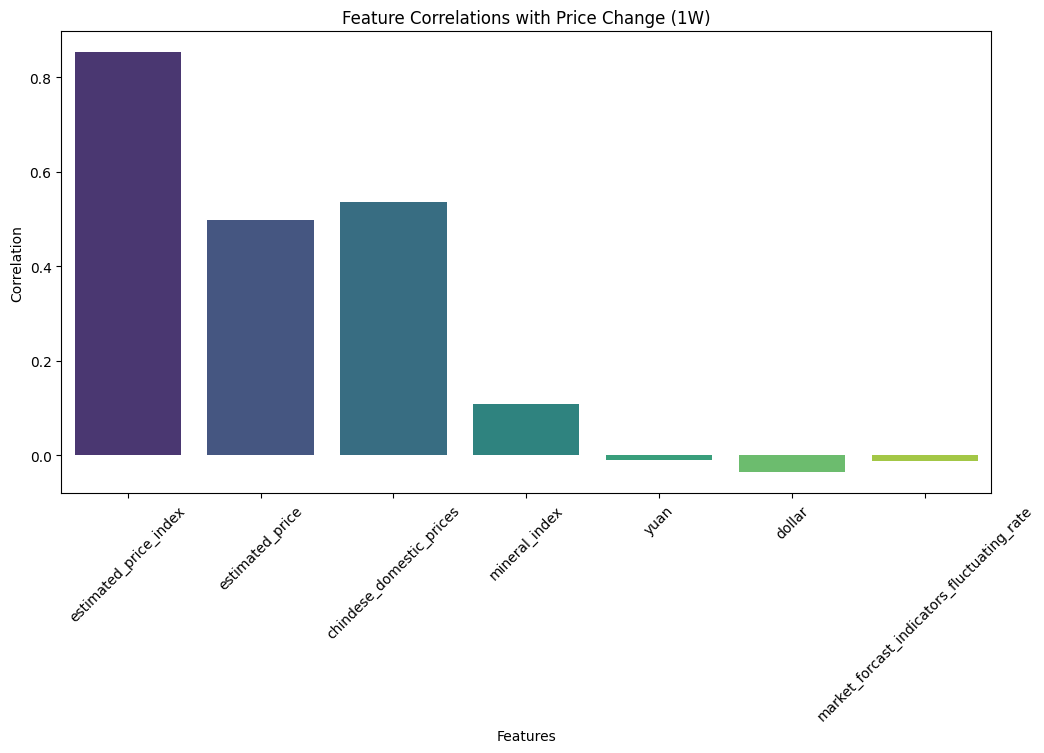

Correlations for period: 1M
estimated_price_index: 0.8440252512141976
estimated_price: 0.596515704151799
chindese_domestic_prices: 0.642250746732936
mineral_index: 0.2783513108909395
yuan: 0.020907118878414618
dollar: 0.0019753483448929085
market_forcast_indicators_fluctuating_rate: -0.008166076960334424




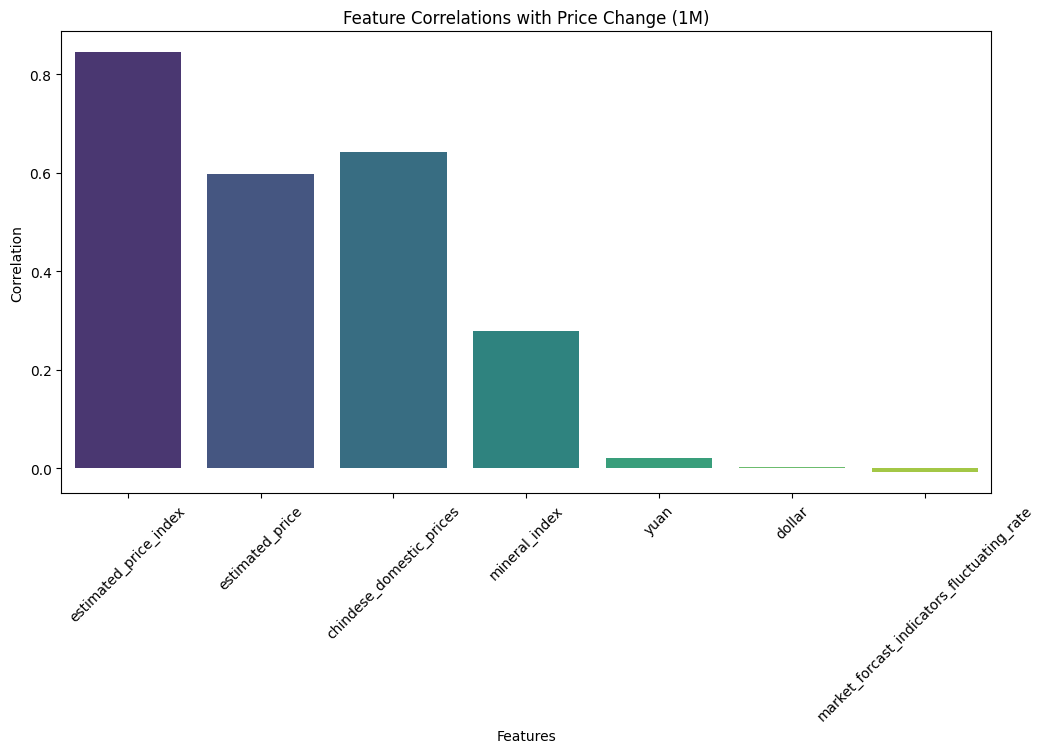

Correlations for period: 3M
estimated_price_index: 0.9056280376838978
estimated_price: 0.7708342636480044
chindese_domestic_prices: 0.8104854657342041
mineral_index: 0.5623582158733097
yuan: -0.12550825982590127
dollar: -0.039735217162083704
market_forcast_indicators_fluctuating_rate: -0.03895403907748246




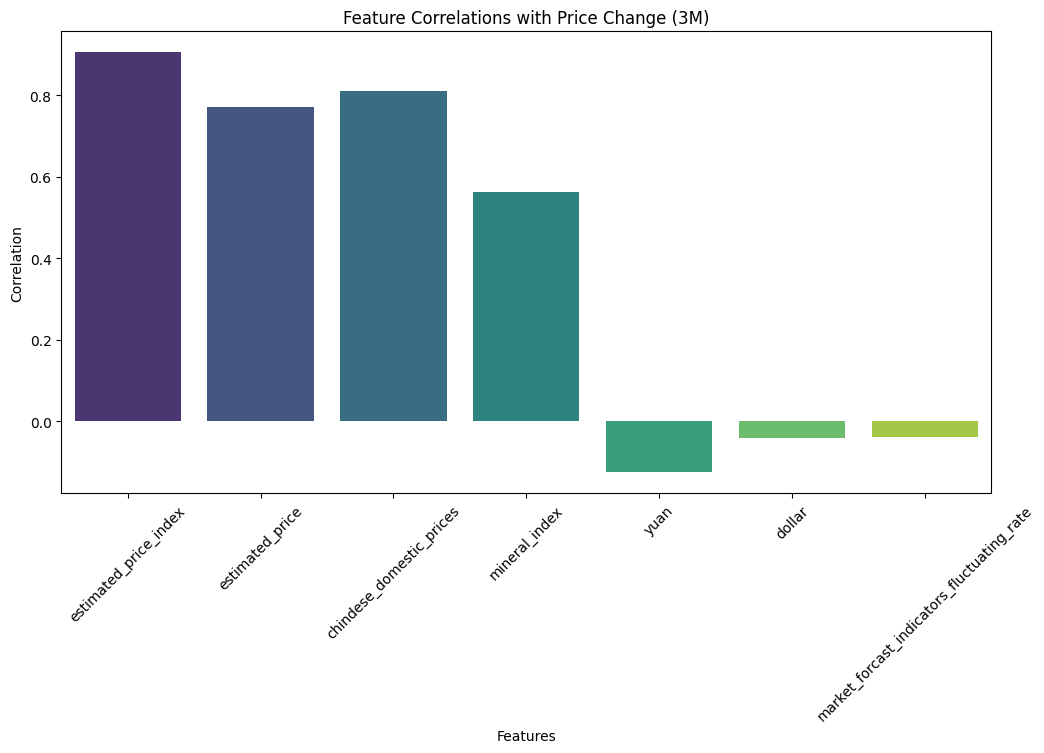

In [ ]:
# 필요한 특성 선택
features = ['estimated_price_index', 'estimated_price', 'chindese_domestic_prices',
            'mineral_index',  'yuan', 'dollar',
            'market_forcast_indicators_fluctuating_rate']
# 특정 기간 동안의 실제 가격 변동 계산
def calculate_price_change(df, period='1W'):
    return df[target].pct_change().resample(period).sum()

# 변수 변동 계산
def calculate_feature_changes(df, features, period='1W'):
    feature_changes = {}
    for feature in features:
        feature_changes[feature] = df[feature].pct_change().resample(period).sum()
    return pd.DataFrame(feature_changes)

# 상관 분석
def calculate_correlations(price_change, feature_changes):
    correlations = {}
    for feature in feature_changes.columns:
        correlations[feature] = price_change.corr(feature_changes[feature])
    return correlations

# 시각화 함수
def plot_correlations(correlations, period):
    features = list(correlations.keys())
    correlation_values = list(correlations.values())

    plt.figure(figsize=(12, 6))
    sns.barplot(x=features, y=correlation_values, palette='viridis')
    plt.title(f'Feature Correlations with Price Change ({period})')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.show()

# 특정 기간 설정 (예: 최근 1주일, 1달, 3달)
periods = ['1W', '1M', '3M']

for period in periods:
    # 실제 가격 변동 계산
    price_change = calculate_price_change(df_interpolated, period)

    # 변수 변동 계산
    feature_changes = calculate_feature_changes(df_interpolated, features, period)

    # 상관 분석
    correlations = calculate_correlations(price_change, feature_changes)

    # 결과 출력 및 시각화
    print(f"Correlations for period: {period}")
    for feature, correlation in correlations.items():
        print(f"{feature}: {correlation}")
    print("\n")

    # 시각화
    plot_correlations(correlations, period)

Correlations for period: 1W
yuan: -0.010685270838430978
dollar: -0.03633081946407507




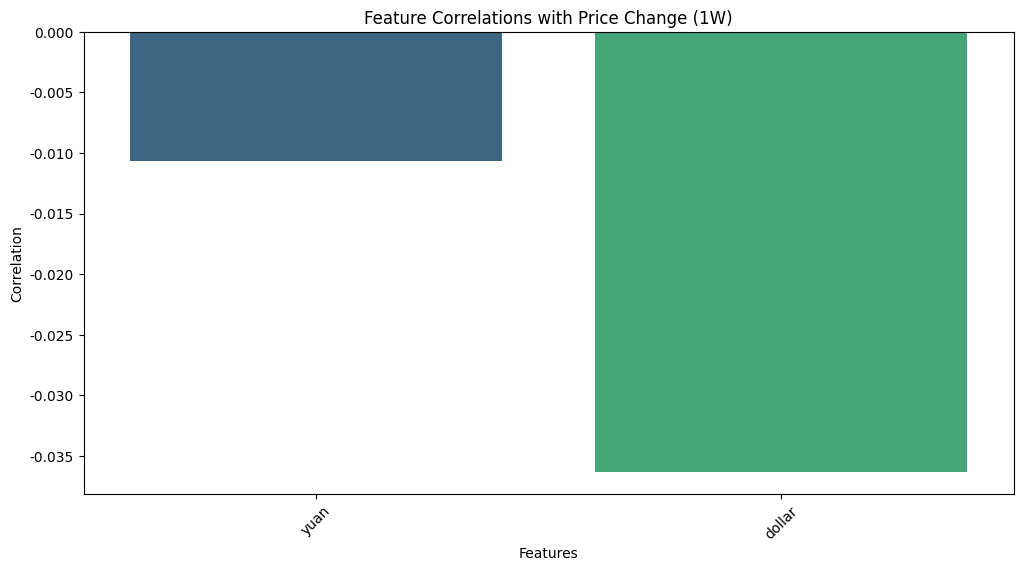

Correlations for period: 1M
yuan: 0.020907118878414618
dollar: 0.0019753483448929085




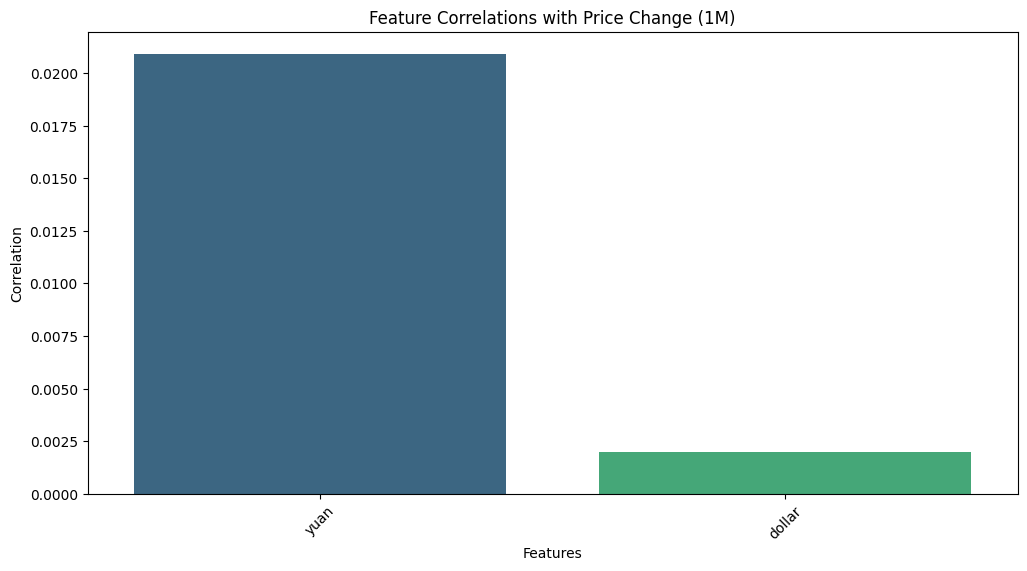

Correlations for period: 3M
yuan: -0.12550825982590127
dollar: -0.039735217162083704




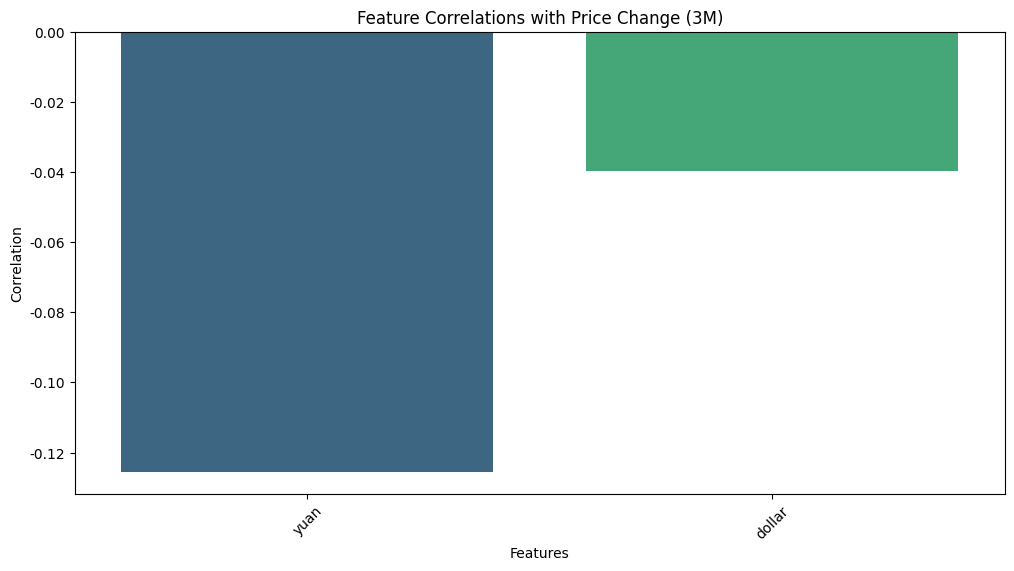

In [ ]:
# 필요한 특성 선택
features = [
             'yuan', 'dollar']
# 특정 기간 동안의 실제 가격 변동 계산
def calculate_price_change(df, period='1W'):
    return df[target].pct_change().resample(period).sum()

# 변수 변동 계산
def calculate_feature_changes(df, features, period='1W'):
    feature_changes = {}
    for feature in features:
        feature_changes[feature] = df[feature].pct_change().resample(period).sum()
    return pd.DataFrame(feature_changes)

# 상관 분석
def calculate_correlations(price_change, feature_changes):
    correlations = {}
    for feature in feature_changes.columns:
        correlations[feature] = price_change.corr(feature_changes[feature])
    return correlations

# 시각화 함수
def plot_correlations(correlations, period):
    features = list(correlations.keys())
    correlation_values = list(correlations.values())

    plt.figure(figsize=(12, 6))
    sns.barplot(x=features, y=correlation_values, palette='viridis')
    plt.title(f'Feature Correlations with Price Change ({period})')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.show()

# 특정 기간 설정 (예: 최근 1주일, 1달, 3달)
periods = ['1W', '1M', '3M']

for period in periods:
    # 실제 가격 변동 계산
    price_change = calculate_price_change(df_interpolated, period)

    # 변수 변동 계산
    feature_changes = calculate_feature_changes(df_interpolated, features, period)

    # 상관 분석
    correlations = calculate_correlations(price_change, feature_changes)

    # 결과 출력 및 시각화
    print(f"Correlations for period: {period}")
    for feature, correlation in correlations.items():
        print(f"{feature}: {correlation}")
    print("\n")

    # 시각화
    plot_correlations(correlations, period)

In [ ]:
df = pd.read_csv(file_path)

df.head()

,date,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,...,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices,mineral_variation_index,economic_index,estimated_price_index
0,2018-01-01,-5.5,1071.4,-0.18,163.65,48.000000,150.0,0.0,0.00,1844.20,...,0.82,4.550000,-0.090000,-1.960000,145.540000,4.480432,152.422786,212.819749,85.265900,118.680000
1,2018-01-02,-5.5,1071.4,-0.18,163.65,48.032258,150.0,0.0,0.00,1844.20,...,0.82,4.559355,-0.077742,-1.688065,145.325778,4.499538,152.333911,212.819749,85.265900,118.574760
2,2018-01-03,3.5,1064.3,0.23,163.82,48.064516,151.0,1.0,0.67,1859.25,...,0.82,4.568710,-0.065484,-1.416129,145.111556,4.518644,152.245035,212.819749,85.265900,118.769520
3,2018-01-04,-1.0,1065.4,0.04,163.90,48.096774,150.0,-1.0,-0.66,1858.27,...,-0.05,4.578065,-0.053226,-1.144194,144.897333,4.537750,152.156160,216.410958,85.927141,118.364280
4,2018-01-05,-1.0,1065.5,0.32,163.92,48.129032,150.0,0.0,0.00,1869.72,...,0.62,4.587419,-0.040968,-0.872258,144.683111,4.556856,152.067285,200.804340,84.122673,118.259039


In [ ]:
df.dtypes

date                                           object
increase_yuan                                 float64
yuan                                          float64
increase_dollar                               float64
dollar                                        float64
search                                        float64
price                                         float64
fluctuating_price                             float64
fluctuation_rate                              float64
mineral_index                                 float64
mineral_index_fluctuating                     float64
mineral_index_rate                            float64
market_forcast_indicators                     float64
market_forcast_indicators_fluctuating         float64
market_forcast_indicators_fluctuating_rate    float64
estimated_price                               float64
stabilization_index                           float64
chindese_domestic_prices                      float64
mineral_variation_index     

In [ ]:
# 주요 변수들
columns_of_interest = ['yuan','dollar','search','price','mineral_index','market_forcast_indicators_fluctuating_rate','estimated_price','chindese_domestic_prices','estimated_price_index']


In [ ]:
# 기간 설정
df_period = df[(df['date'] >= '2023-05-01') & (df['date'] <= '2024-05-31')]

# 4분기
periods = [
    ('2023-04-01', '2023-06-31'),
    ('2023-07-01', '2023-09-31'),
    ('2023-10-01', '2024-12-31'),
    ('2024-01-01', '2024-03-30'),
    ('2024-04-01', '2024-05-31')
]

corr_data = {}

for start, end in periods:
    period_df = df_period[(df_period['date'] >= start) & (df_period['date'] <= end)]
    period_corr = period_df[columns_of_interest].corr().abs()['price'].drop('price')
    period_label = f"{start[:7]}~{end[:7]}"
    corr_data[period_label] = period_corr

# DF 만들기
corr_df = pd.DataFrame(corr_data)


In [ ]:
corr_df_transposed = corr_df.T

In [ ]:
corr_df_transposed

,yuan,dollar,search,mineral_index,market_forcast_indicators_fluctuating_rate,estimated_price,chindese_domestic_prices,estimated_price_index
2023-04~2023-06,0.745768,0.900013,0.953192,0.437449,0.983016,0.904008,NaN,0.997708
2023-07~2023-09,0.781806,0.737319,0.918966,0.572731,0.899697,0.989664,NaN,0.997419
2023-10~2024-12,0.250130,0.111568,0.702812,0.140566,0.535691,0.877491,NaN,0.977548
2024-01~2024-03,0.173101,0.038179,0.482464,0.184839,0.811953,0.875335,NaN,0.998837
2024-04~2024-05,0.434105,0.431677,0.307687,0.271485,NaN,NaN,NaN,1.000000


from matplotlib import pyplot as plt
corr_df_transposed['yuan'].plot(kind='hist', bins=20, title='yuan')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed['dollar'].plot(kind='hist', bins=20, title='dollar')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed['search'].plot(kind='hist', bins=20, title='search')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed['mineral_index'].plot(kind='hist', bins=20, title='mineral_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed.plot(kind='scatter', x='yuan', y='dollar', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed.plot(kind='scatter', x='dollar', y='search', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed.plot(kind='scatter', x='search', y='mineral_index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed.plot(kind='scatter', x='mineral_index', y='market_forcast_indicators_fluctuating_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed['yuan'].plot(kind='line', figsize=(8, 4), title='yuan')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed['dollar'].plot(kind='line', figsize=(8, 4), title='dollar')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed['search'].plot(kind='line', figsize=(8, 4), title='search')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
corr_df_transposed['mineral_index'].plot(kind='line', figsize=(8, 4), title='mineral_index')
plt.gca().spines[['top', 'right']].set_visible(False)

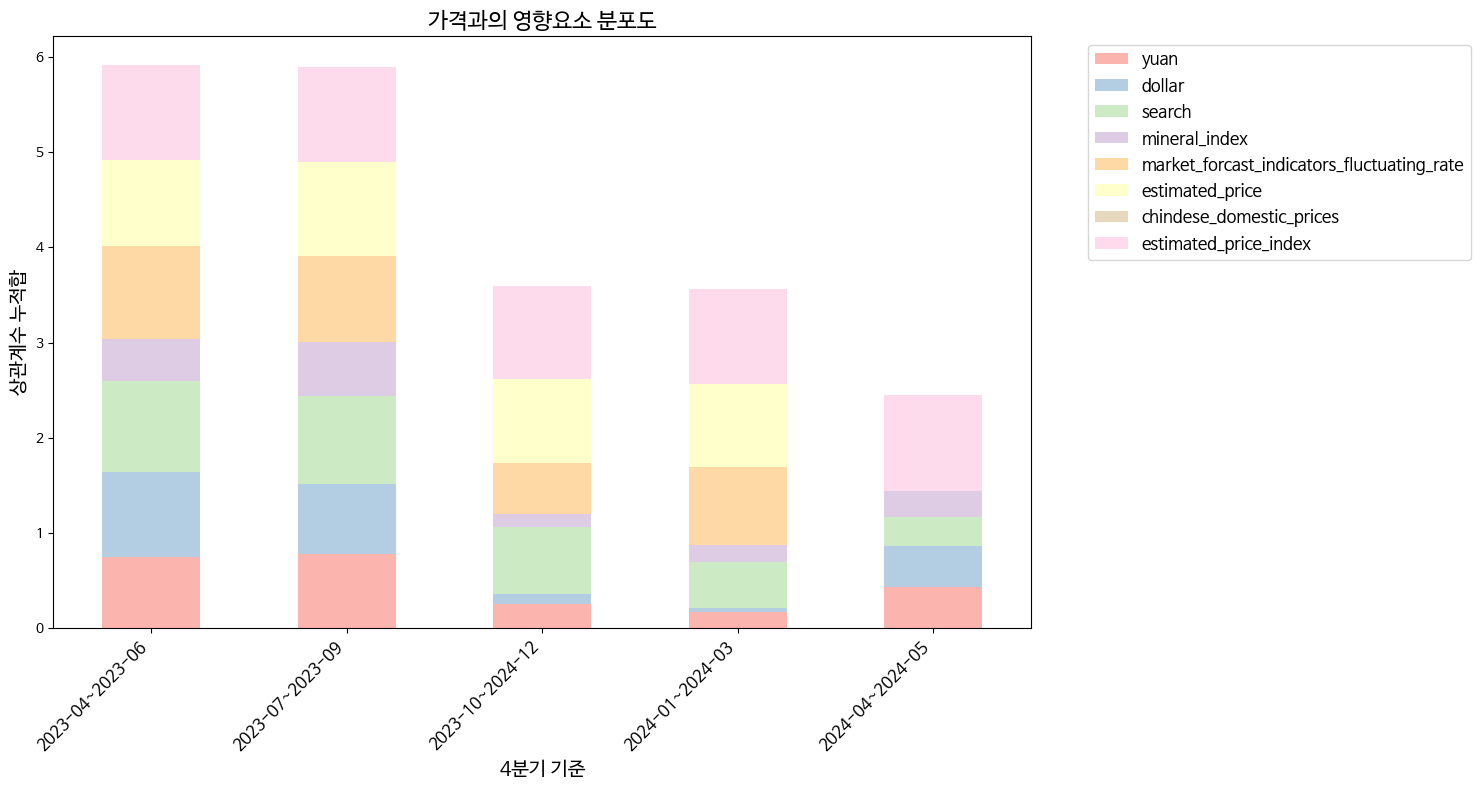

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
# 색상 팔레트 설정
colors = sns.color_palette("Pastel1", n_colors=len(columns_of_interest))

# 누적 바 그래프 그리기
ax = corr_df_transposed.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors)
ax.set_xlabel('4분기 기준', fontsize=14)
ax.set_ylabel('상관계수 누적합', fontsize=14)
ax.set_title('가격과의 영향요소 분포도', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# 그래프 저장 및 출력
plt.tight_layout()
plt.show()


In [ ]:
corr_df_transposed

,yuan,dollar,search,mineral_index,market_forcast_indicators_fluctuating_rate,estimated_price,chindese_domestic_prices,estimated_price_index
2023-05~2023-07,0.615307,0.823172,0.863934,0.275271,0.921611,0.171898,NaN,0.869083
2023-08~2023-10,0.811922,0.701352,0.937992,0.124923,0.050020,0.949966,NaN,0.986328
2023-11~2024-01,0.072948,0.541927,0.628478,0.377330,0.114930,0.943915,NaN,0.994590
2024-02~2024-04,0.576942,0.520481,0.529459,0.608823,0.949228,0.949195,NaN,0.998701
2024-05~2024-05,0.534814,0.767035,NaN,0.487491,NaN,NaN,NaN,1.000000


In [ ]:
data = pd.read_csv(file_path)

# 날짜 형식 변환
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# 2023년 1월부터 12월까지의 데이터 필터링
data_filtered = data[(data['date'] >= '2023-01-01') & (data['date'] <= '2023-12-31')]

# 월별 데이터 그룹화
monthly_data = data_filtered.resample('M', on='date').mean()

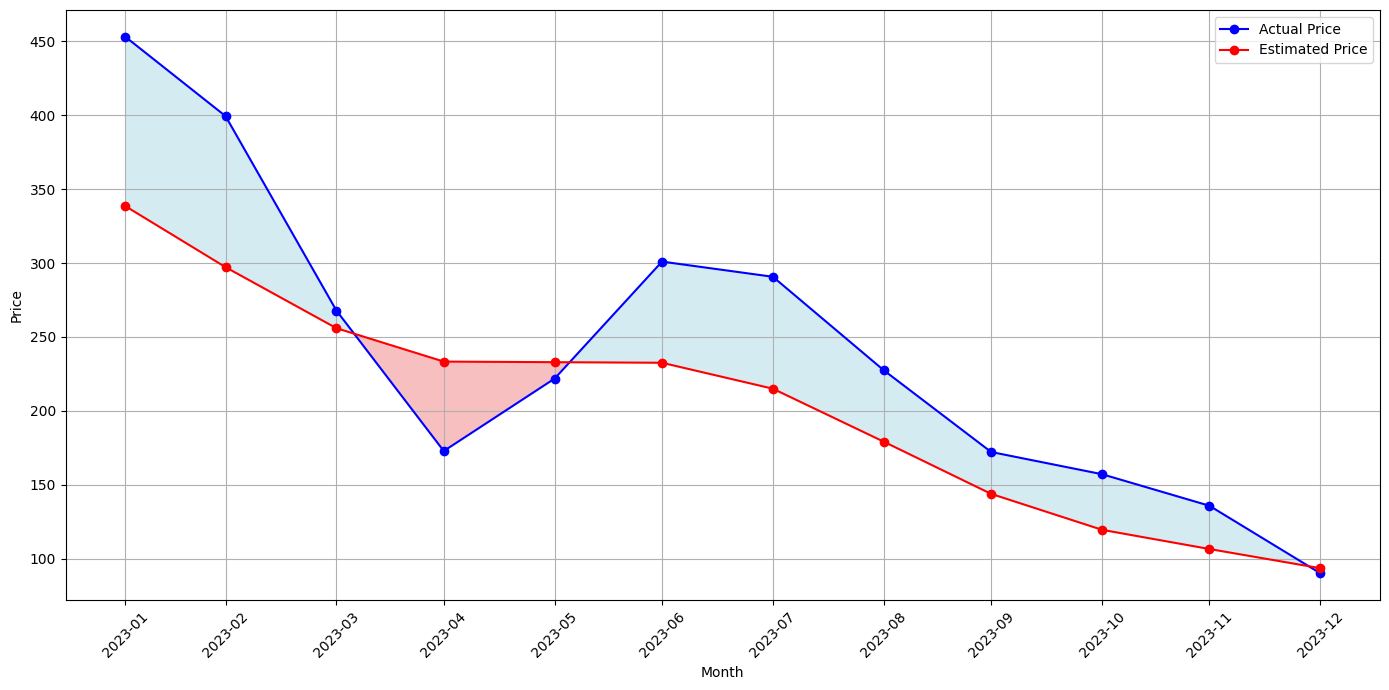

In [ ]:
# 시각화
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['price'], marker='o', label='Actual Price', color='blue')
plt.plot(monthly_data.index, monthly_data['estimated_price'], marker='o', label='Estimated Price', color='red')
plt.fill_between(monthly_data.index, monthly_data['price'], monthly_data['estimated_price'],
                 where=(monthly_data['price'] >= monthly_data['estimated_price']),
                 facecolor='lightblue', interpolate=True, alpha=0.5)
plt.fill_between(monthly_data.index, monthly_data['price'], monthly_data['estimated_price'],
                 where=(monthly_data['price'] < monthly_data['estimated_price']),
                 facecolor='lightcoral', interpolate=True, alpha=0.5)

plt.xlabel('Month')
plt.ylabel('Price')
plt.xticks(monthly_data.index, monthly_data.index.strftime('%Y-%m'), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM 모델링

In [ ]:
# 코드를 실행하기 위한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
file_path = '/content/drive/MyDrive/산업통상자원부/데이터/final_lithium_data.csv'
df_interpolated = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

df_interpolated.head()

,increase_yuan,yuan,increase_dollar,dollar,search,price,fluctuating_price,fluctuation_rate,mineral_index,mineral_index_fluctuating,mineral_index_rate,market_forcast_indicators,market_forcast_indicators_fluctuating,market_forcast_indicators_fluctuating_rate,estimated_price,stabilization_index,chindese_domestic_prices,mineral_variation_index,economic_index,estimated_price_index
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,-5.5,1071.4,-0.18,163.65,48.000000,150.0,0.0,0.00,1844.20,15.06,0.82,4.550000,-0.090000,-1.960000,145.540000,4.480432,152.422786,212.819749,85.265900,118.680000
2018-01-02,-5.5,1071.4,-0.18,163.65,48.032258,150.0,0.0,0.00,1844.20,15.06,0.82,4.559355,-0.077742,-1.688065,145.325778,4.499538,152.333911,212.819749,85.265900,118.574760
2018-01-03,3.5,1064.3,0.23,163.82,48.064516,151.0,1.0,0.67,1859.25,15.06,0.82,4.568710,-0.065484,-1.416129,145.111556,4.518644,152.245035,212.819749,85.265900,118.769520
2018-01-04,-1.0,1065.4,0.04,163.90,48.096774,150.0,-1.0,-0.66,1858.27,-0.98,-0.05,4.578065,-0.053226,-1.144194,144.897333,4.537750,152.156160,216.410958,85.927141,118.364280
2018-01-05,-1.0,1065.5,0.32,163.92,48.129032,150.0,0.0,0.00,1869.72,11.44,0.62,4.587419,-0.040968,-0.872258,144.683111,4.556856,152.067285,200.804340,84.122673,118.259039


In [ ]:
# 시드 값 설정 : 재현성을 위해 시드 값을 42로 설정
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
# y값 설정
target = 'price'

# Min-Max 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_interpolated[target].values.reshape(-1, 1))

In [ ]:
# 데이터셋 생성
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 예시: 30일 간의 데이터를 사용하여 다음 날을 예측
time_step = 30
X, y = create_dataset(scaled_data, time_step)

In [ ]:
# 데이터셋 분할 (Train 80%, Test 20%)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [ ]:
# 날짜 인덱스 생성 : 시각화를 위해 인덱스 생성
train_dates = df_interpolated.index[:train_size]
test_dates = df_interpolated.index[train_size:len(df_interpolated)]

In [ ]:
# LSTM 모델 입력 형식에 맞게 데이터를 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Epoch 1/50
29/29 [==============================] - 6s 40ms/step - loss: 0.0284 - val_loss: 0.0047
Epoch 2/50
29/29 [==============================] - 0s 11ms/step - loss: 6.3040e-04 - val_loss: 0.0026
Epoch 3/50
29/29 [==============================] - 0s 12ms/step - loss: 3.2458e-04 - val_loss: 0.0019
Epoch 4/50
29/29 [==============================] - 0s 13ms/step - loss: 3.1016e-04 - val_loss: 0.0022
Epoch 5/50
29/29 [==============================] - 0s 12ms/step - loss: 3.3013e-04 - val_loss: 0.0021
Epoch 6/50
29/29 [==============================] - 0s 12ms/step - loss: 2.7673e-04 - val_loss: 0.0016
Epoch 7/50
29/29 [==============================] - 0s 14ms/step - loss: 2.7722e-04 - val_loss: 0.0019
Epoch 8/50
29/29 [==============================] - 0s 13ms/step - loss: 2.6074e-04 - val_loss: 0.0015
Epoch 9/50
29/29 [==============================] - 0s 11ms/step - loss: 2.8207e-04 - val_loss: 0.0013
Epoch 10/50
29/29 [==============================] - 0s 9ms/step - loss: 2.51

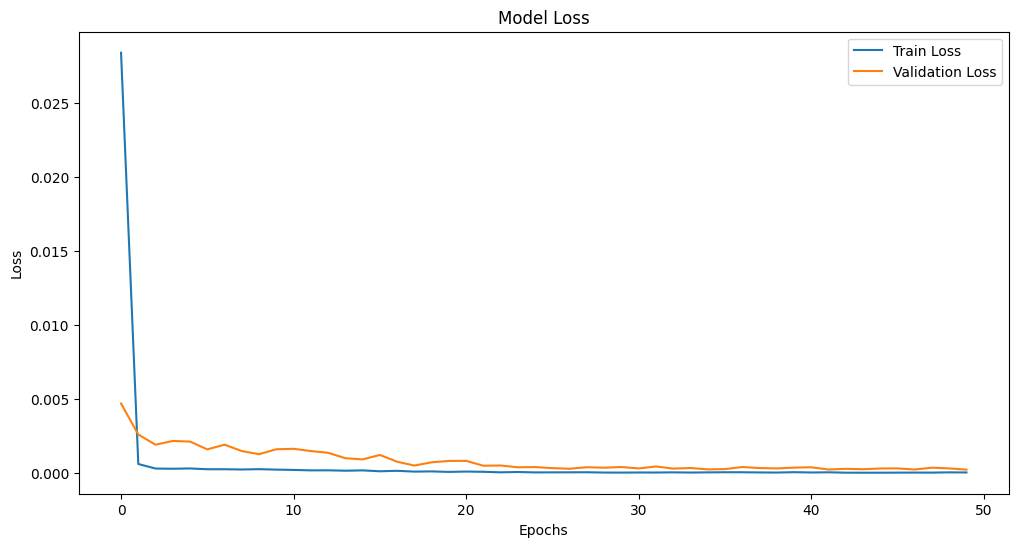

15/15 [==============================] - 0s 5ms/step
Train RMSE: 3.492830848944553
Test RMSE: 8.685530504261374


In [ ]:
from keras.optimizers import Adam
# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1), activation='tanh'))
model.add(LSTM(50, return_sequences=False, activation='tanh'))
model.add(Dense(25, activation='relu'))  # Dense 레이어 노드 수 및 활성화 함수 추가
model.add(Dense(1))

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


# 모델 훈련
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), verbose=1)

# 결과 시각화

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 예측 및 RMSE 계산
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

In [ ]:
train_predict.shape

(1849, 1)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*ar

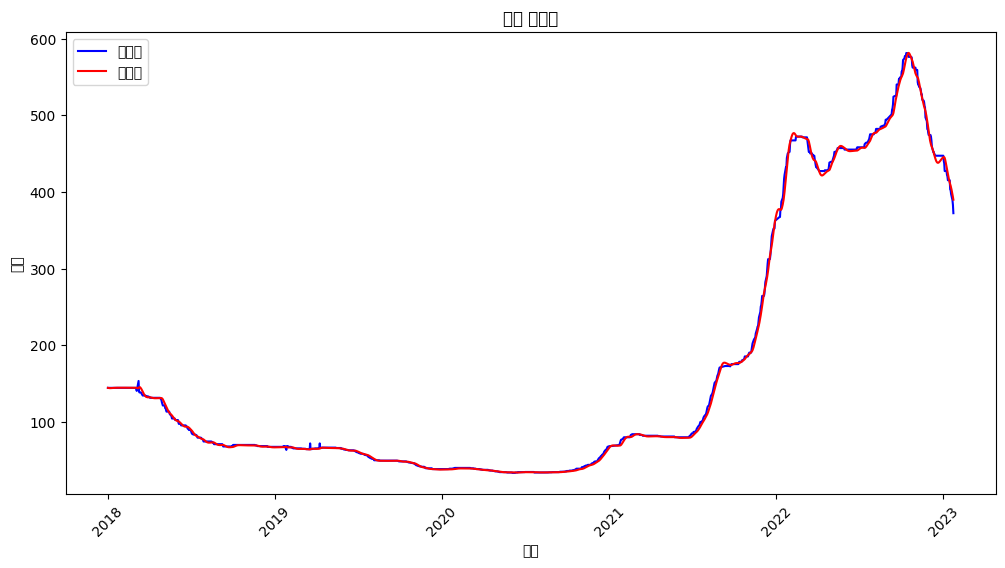

In [ ]:

# 훈련 데이터 시각화

from matplotlib.dates import DateFormatter

plt.figure(figsize=(12, 6))
plt.plot(train_dates, y_train_actual, label='실제값', color = 'Blue')
plt.plot(train_dates, train_predict, label='예측값', color = 'Red')
plt.title('훈련 데이터')
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

In [ ]:
# 데이터프레임 생성
df_train = pd.DataFrame({
    'Date': train_dates,
    'Actual': y_train_actual.flatten(),
    'Predicted': train_predict.flatten()
})

# 'Date'를 인덱스로 설정
df_train.set_index('Date', inplace=True)

df_train.head()

,Actual,Predicted
Date,,
2018-01-01,144.5,144.515778
2018-01-02,144.5,144.366364
2018-01-03,144.5,144.255051
2018-01-04,144.5,144.180161
2018-01-05,144.5,144.137329


In [ ]:
# 파일 추출
df_train.to_csv('df_train.csv')

In [ ]:
# test_dates의 길이를 y_test의 길이에 맞추기
start_idx = len(df_interpolated) - len(y_test)
test_dates = df_interpolated.index[start_idx:]

<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ed2167500f7d>:12: UserWarning: Glyph 4

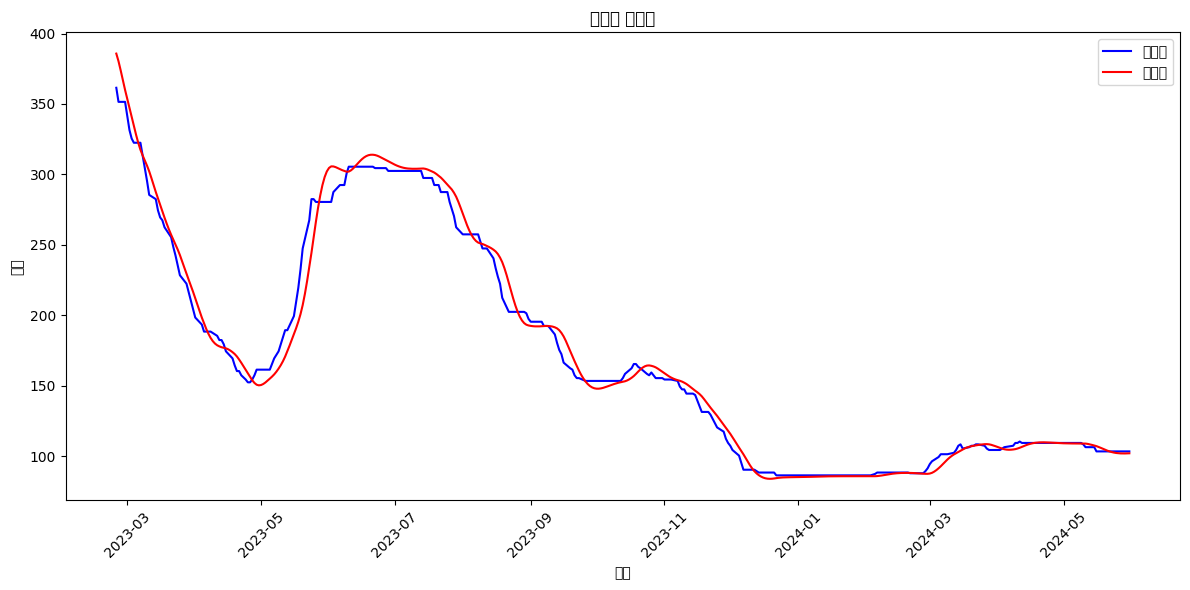

In [ ]:
# 테스트 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='실제값', color = 'Blue')
plt.plot(test_dates, test_predict, label='예측값', color = 'Red')
plt.title('테스트 데이터')
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [ ]:
# 데이터프레임 생성
df_test = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_actual.flatten(),
    'Predicted': test_predict.flatten()
})

# 'Date'를 인덱스로 설정
df_test.set_index('Date', inplace=True)

df_test.head()

,Actual,Predicted
Date,,
2023-02-24,361.5,385.752991
2023-02-25,351.5,380.353027
2023-02-26,351.5,373.805603
2023-02-27,351.5,366.828888
2023-02-28,351.5,359.964233


In [ ]:
# 파일 추출
df_test.to_csv('df_test.csv')